# ES Querying

Produce sentiment monitoring graphs

In [6]:
import numpy as np
import pandas as pd
import pickle as pkl
import json, time, os
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch
%matplotlib inline
search_term = 'brexit'

### Query

In [ ]:
es = Elasticsearch([{'host': 'localhost', 'port': 9200}]) ## Connect to ES

In [ ]:
## Define search query object 

corpus = "corpus1.1"
search_term = 'brexit'

search_object = {'query': {'match': {'content': search_term}}}
sch_obj = es.search(index=corpus, body=search_object, size=10000)

### Curate

In [ ]:
## Fetch hits and retrieve texts, publications, dates

hits = sch_obj['hits']['hits']
documents = [text['_source']['content'] for text in hits]
publications = [ text['_source']['publication'] for text in hits]
dates = [text['_source']['date'] for text in hits]

In [ ]:
## Organize into formatted df

data = pd.DataFrame()

data['documents'] = documents
data['publications'] = publications

data['dates'] = dates
data['dates'] = data.dates.str[:10].astype('datetime64[ns]')
data['dates_period'] = pd.PeriodIndex(data.dates, freq='M')

data.to_pickle('raw_query_data')
data.info()

### Sentiment Analysis 

In [ ]:
import spacy
import en_core_web_sm
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
nlp = en_core_web_sm.load()

In [ ]:
def get_relevant_sentences(doc, entity):
    
    """
    Description: 
        Fetches only sentences with requested entity
    Parameters: 
        doc: Input Document (str)
        entity: Term to calculate sentiment for (str)
    Returns: 
        entity_sentences: Sentences containing specificied entity (list)
    """

    sentences = [sent.string.strip() for sent in nlp(doc).sents]
    entity_sentences = [s for s in sentences if entity in s.lower()]        
    
    return entity_sentences

In [ ]:
def gen_doc_sentiment(doc, method = 'vader', sensitivity = .75, entity = search_term):
       
    """
    Description: 
        Classifies document sentiment by calculating sentence sentiment distributions
        (0: positive, 1: negative, 2: neutral)
    Parameters: 
        doc: Document to classify (str)
        method: Method to calculate sentiments (str)
        sensitivity: Threshold for determining sentence / document sentiment classification (float)
        entity: Term to calculate sentiment for (str)
    Returns: 
        classification: Document sentiment classification (str)
    """
    
    sentences = get_relevant_sentences(doc, entity)
    classification = ''
    sent_senti = [0,0,0,0]
    
    if method == 'blob':

        ## Determine sentence sentiment distribution
        
        for s in sentences: 
            
            tb = TextBlob(s).sentiment
                
            if tb.subjectivity > sensitivity: 
                sent_senti[2]+=1         
            else: 
                if tb.polarity > (1 - sensitivity):        
                    sent_senti[0]+=1
                elif tb.polarity < (sensitivity - 1):    
                    sent_senti[1]+=1    
                else:
                    sent_senti[2]+=1
                    
        doc_senti = [x / len(sentences) for x in sent_senti]
        
        if doc_senti[2] > sensitivity:
            classification = 'neutral'
        else:    
            if doc_senti[0] > doc_senti[1]:
                classification = 'negative'
            elif doc_senti[1] > doc_senti[0]: 
                classification = 'positive'   
            else:
                classification = 'neutral'

    elif method == 'vader':
        
        analyser = SentimentIntensityAnalyzer()

        ## Determine sentence sentiment distribution
        
        for s in sentences:  
            
            score = analyser.polarity_scores(s)

            if score['neu'] > sensitivity:
                sent_senti[2]+=1    
            else: 
                if score['compound'] > (1 - sensitivity):        
                    sent_senti[0]+=1        
                elif score['compound'] < (sensitivity -1 ):    
                    sent_senti[1]+=1   
                else:
                    sent_senti[2]+=1 
                    
        doc_senti = [x / len(sentences) for x in sent_senti]
            
        ## Determine document sentiment
        
        if doc_senti[2] > sensitivity:
            classification = 'neutral'
        else:    
            if doc_senti[0] > doc_senti[1]:
                classification = 'positive'
            elif doc_senti[1] > doc_senti[0]: 
                classification = 'negative'  
            else:
                classification = 'neutral' 

    return classification

In [ ]:
def gen_corpus_sentiments(df, text_col, entity, methods):
    
    """
    Description: 
        Calculate sentiments for a corpus of documents 
    Parameters:
        df: Corpus of documents (dataframe)
        text_col: Column containing raw text (str)
        entity: Term to calculate sentiment for (str)
        methods: List containing s.analysis methods w/ associated hyperparameters and variables (list)
    Returns:
        df: Dataframe w/ document sentiments
    """

    vader_final, blob_final = ([] for i in range(2))

    for i, doc in enumerate(df[text_col]):
        
        for m in methods:

            method_name = m[0]
            method_sensitivity = m[2]
            
            m[1].append(gen_doc_sentiment(doc, method_name, method_sensitivity, entity))

        print("Sentiment Tagging Progress: {:2.2%}".format(round(((i/df.shape[0])), 3)), end="\r")

    for m in methods:
        df[m[0] + '_final'] = m[1]
    
    df.index.name = 'data_index'
    
    return df

In [ ]:
def total_article_counts(df, methods, aggregator = 'minmax'):
    
    """
    Description: 
        Combines different sentiment scores to calculate final sentiment score for documents
    Parameters:
        df: Corpus of documents (dataframe)    
        methods: List containing s.analysis methods w/ associated hyperparameters and variables (list)
        aggregator: Method of calculating final sentiment score
    Returns:
        df: Corpus of documents with final sentiment scores (dataframe) 
    """
    print ([m[0] + '_final' for m in methods])
    
    df = pd.get_dummies(df, columns = [m[0] + '_final' for m in methods])
    
    if aggregator == 'mean':
        
        df['total_final_negative'] = df[[m[0] + '_final_negative' for m in methods]].mean(axis=1)
        df['total_final_positive'] = df[[m[0] + '_final_positive' for m in methods]].mean(axis=1)
        df['total_final_neutral'] =  df[[m[0] + '_final_neutral'  for m in methods]].mean(axis=1)

    elif aggregator == 'minmax':

        df['total_final_negative'] = df[[m[0] + '_final_negative' for m in methods]].max(axis=1)
        df['total_final_positive'] = df[[m[0] + '_final_positive' for m in methods]].max(axis=1)
        df['total_final_neutral'] =  df[[m[0] + '_final_neutral'  for m in methods]].min(axis=1)
    
    return df

In [ ]:
## Calculate sentiments for each doc in corpus

data = pd.read_pickle('raw_query_data')
#data = data.head(100)

strategies = [['vader', [], .75], ['blob', [], .75]]   

data = gen_corpus_sentiments(df = data, text_col = 'documents', entity = search_term, methods = strategies)
data = total_article_counts(df = data, methods = strategies, aggregator = 'minmax')
data.to_pickle('sentiment_tagged_data')

### Graphing Sentiment

In [47]:
data = pd.read_pickle('sentiment_tagged_data')
data['dates_period'] = data['dates_period'].astype('str')
data['dates'] = data['dates'].astype('str')
#data.info()

In [48]:
def gen_pub_aggregates(df, sentiment, y_axes = 'count'):
    
    """
    Description: 
        Generate table of a given sentiment aggregated by month, by publication
    Parameters: 
        df: Dataframe w/ sentiment scores
        y_axes: Determine axes as article count or ratio
        sentiment: Specific sentiment to generate table on (str)
    Returns: 
        table: Final publication sentiment aggregated by month (dataframe) 
    """
    
    df_lst = []
    pubs = []
    
    table = pd.DataFrame()
    table['dates_period'] = list(df.dates_period.sort_values().unique())

    for i, pub in enumerate(list(df.publications.unique())):

        ## Filter to specific publication
        temp_df = df[df.publications == pub]
        
        ## Aggregate scores on dates_period
        agg_df = temp_df.groupby('dates_period').agg('sum')
        agg_df['dates_period'] = list(agg_df.index.to_series().astype('str'))
           
        if y_axes == 'ratio':
            filt = list(set(agg_df.columns) - set(['dates_period', 'data_index']))
            agg_df[filt] = agg_df[filt]/df.publications.value_counts()[pub]

        df_lst.append(agg_df[["total_final_" + sentiment]].add_suffix('_' + pub))
        
        pubs.append(pub)

    table = pd.concat(df_lst, axis=1, sort=True)
    table = table.fillna(0)

    return table, pubs

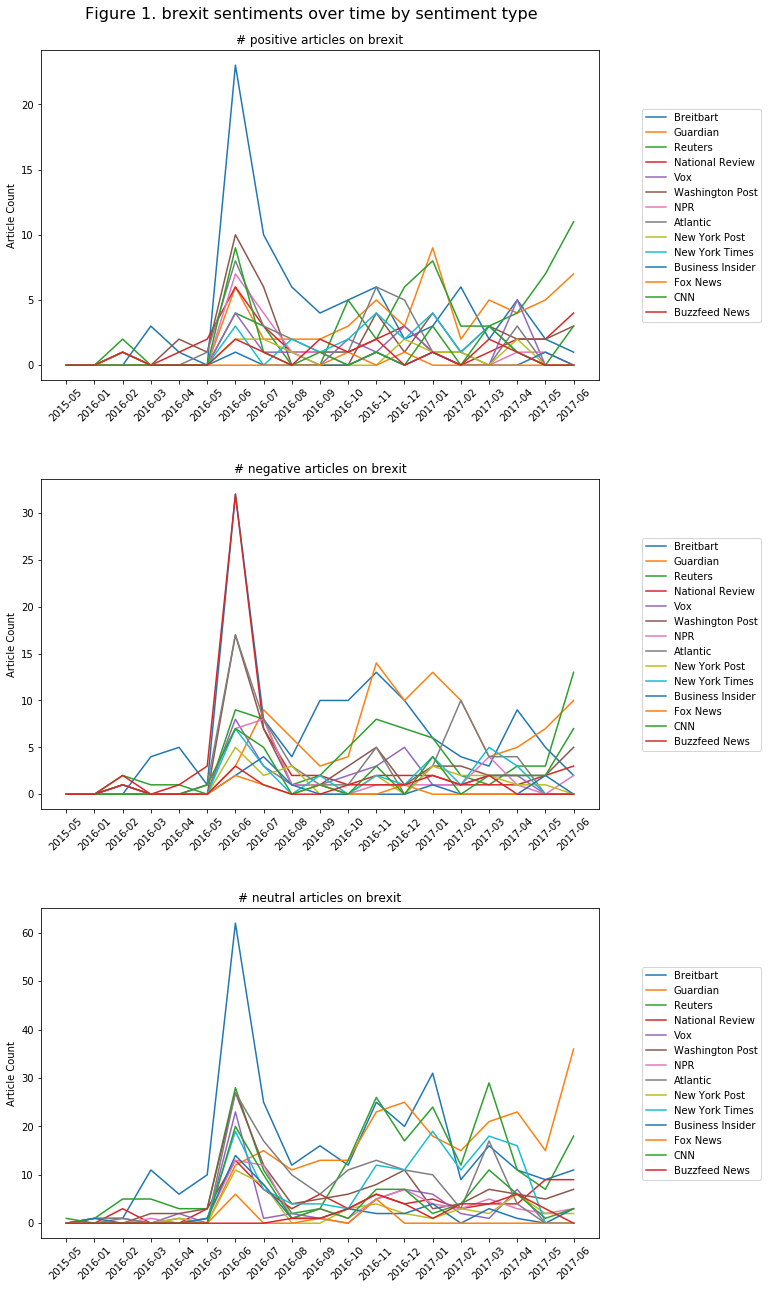

In [49]:
## Plot positive, negative and neutral article counts by publication source

fig, axs = plt.subplots(3, 1, figsize=(10, 20))

wspace = 0.3 
hspace = 0.3

plt.subplots_adjust(wspace=wspace, hspace=hspace)

for i, sentiment in enumerate(['positive', 'negative', 'neutral']):

    table, pubs = gen_pub_aggregates(data, sentiment)
    
    #print(table.info(), "\n")

    for ii, col in enumerate(table.columns):
        axs[i].tick_params(axis='x', rotation=45)
        axs[i].plot(table.index, table[col], label=pubs[ii])
    
    
    axs[i].set_ylabel('Article Count')
    axs[i].legend(loc='right', bbox_to_anchor=(1.3, 0.5))
    axs[i].set_title('# ' + sentiment + ' articles on ' + search_term)

fig.suptitle('Figure 1. ' + search_term + ' sentiments over time by sentiment type', fontsize=16)
plt.subplots_adjust(top=0.95)
plt.show()

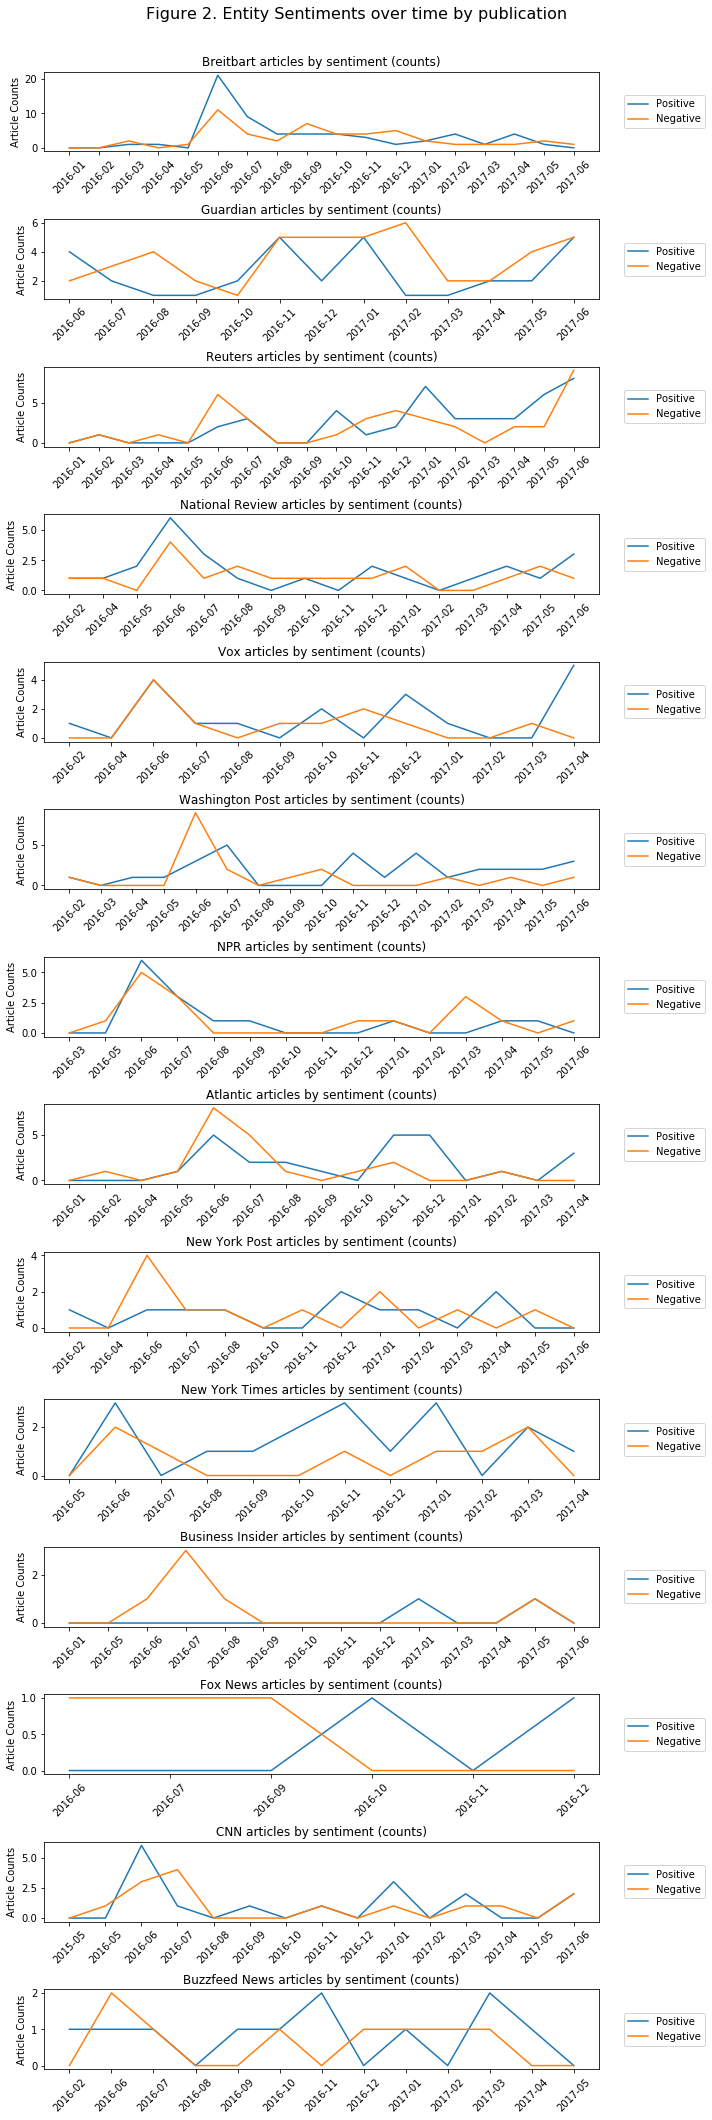

In [50]:
## Seperately plot positive and negative article counts for each publication source 

fig, axs = plt.subplots(14, 1, figsize=(10, 30))

wspace = 0.6 
hspace = 0.6

plt.subplots_adjust(wspace=wspace, hspace=hspace)

for i, pub in enumerate(list(data.publications.unique())):
    
    ## Filter to specific publication
    graph_df = data[data.publications == pub]
    
    ## Aggregate scores on dates_period
    agg_df = graph_df.groupby('dates_period').agg('sum')
    agg_df['dates_period'] = list(agg_df.index.to_series().astype('str'))
        
    axs[i].plot(agg_df['dates_period'], agg_df['vader_final_positive'], label = 'Positive')
    axs[i].plot(agg_df['dates_period'], agg_df['vader_final_negative'], label = 'Negative')
    #axs[i].plot(agg_df['dates_period'], agg_df['vader_final_neutral'], label = 'Neutral')

    axs[i].set_title(pub + ' articles by sentiment (counts)')
    axs[i].set_ylabel('Article Counts')
    axs[i].tick_params(axis='x', rotation=45)

    #axs[i].set_xlabel('Date')
    axs[i].legend(loc='right', bbox_to_anchor=(1.2, 0.5))
    
plt.tight_layout()
plt.subplots_adjust(top=0.95)
fig.suptitle('Figure 2. Entity Sentiments over time by publication', fontsize=16)
plt.show()